In [1]:

# ██████╗░░█████╗░████████╗░█████╗░  ██████╗░██████╗░░█████╗░░█████╗░███████╗░██████╗░██████╗██╗███╗░░██╗░██████╗░
# ██╔══██╗██╔══██╗╚══██╔══╝██╔══██╗  ██╔══██╗██╔══██╗██╔══██╗██╔══██╗██╔════╝██╔════╝██╔════╝██║████╗░██║██╔════╝░
# ██║░░██║███████║░░░██║░░░███████║  ██████╔╝██████╔╝██║░░██║██║░░╚═╝█████╗░░╚█████╗░╚█████╗░██║██╔██╗██║██║░░██╗░
# ██║░░██║██╔══██║░░░██║░░░██╔══██║  ██╔═══╝░██╔══██╗██║░░██║██║░░██╗██╔══╝░░░╚═══██╗░╚═══██╗██║██║╚████║██║░░╚██╗
# ██████╔╝██║░░██║░░░██║░░░██║░░██║  ██║░░░░░██║░░██║╚█████╔╝╚█████╔╝███████╗██████╔╝██████╔╝██║██║░╚███║╚██████╔╝
# ╚═════╝░╚═╝░░╚═╝░░░╚═╝░░░╚═╝░░╚═╝  ╚═╝░░░░░╚═╝░░╚═╝░╚════╝░░╚════╝░╚══════╝╚═════╝░╚═════╝░╚═╝╚═╝░░╚══╝░╚═════╝░

# Spatial Joins: Preamble

In [1]:
import pandas as pd 
import shapely.geometry as geom
import geopandas as gpd
from simpledbf import Dbf5
from unidecode import unidecode
import os
import datetime
import re
import numpy as np
from matplotlib import pyplot as plt

# Set locals for directories
working_dir = "/Users/upar/Library/CloudStorage/OneDrive-UniversidaddelosAndes/03 MONEY/CESED/ANDI"
data_dir = "/Users/upar/Library/CloudStorage/OneDrive-UniversidaddelosAndes/03 MONEY/CESED/ANDI/Datos"
gis_dir = f"{working_dir}/Datos/2-IntermediateData/GIS"

# Test directories

os.listdir(gis_dir)

['1-Delitos sexuales',
 'localidades_estrato_poblacion.qmd',
 '9-Hurto de motocicletas',
 '7-Hurto a residencias',
 '.DS_Store',
 'upz_estrato_poblacion.gpkg',
 '8-Hurto de automotores',
 '4-Violencia intrafamiliar',
 '3-Homicidios',
 'catastral_estrato_poblacion.gpkg',
 'localidades_estrato_poblacion.csv',
 '6-Hurto a personas',
 '10-Hurto a comercios',
 'all_crimes_points.gpkg',
 'all_crimes_points.csv',
 'localidades_estrato_poblacion.gpkg',
 'manzana_censo2018_poblacion.gpkg']

Steps:

1. Importar archivo con delitos georreferenciados [para todos los años/para $t$] a DataFrame de Excel
2. Pasar a un GeoDataFrame `delito_YYYY` y exportar a GeoPackage `delito_YYYY_points.gpkg`
3. Importar GeoDataFrame de localidades `localidades_estrato_poblacion.gpkg`
4. Realizar **spatial join** 
   1. `join=gpd.sjoin(delito_2021,localidades,how="inner", predicate='intersects')`
   2. Revisar que el join haya quedado bien revisando la suma de crímenes totales del año
5. Transformar dataframe grouping by 'LocCodigo', tomando `cantidad` y agregando mediante suma
6. Hacer **merge** de GDF de localidades con dataframe de punto anterior.
7. Exportar geopackage `localidades`

Define auxiliary functions for the steps described above to be easier to code and trace errors.

In [2]:
def spatial_join(left_df:pd.DataFrame, right_df, crime_count_column):
    """
    Makes a right join with intersection predicate.
    Note that the right_df is the one that keeps the
    geometry, thus this should NEVER be the points, always the
    desired polygons to which we want to join the points.
    """
    
    # Rename crime count column
    
    left_df.rename(columns={crime_count_column:'cantidad_delito'}, inplace=True)
    
    # Check that both CRS projections are the same
    test= left_df.crs == right_df.crs
    if test==True:
        print("CRS match.")
    elif test==False:
        print("CRS do not match. Check before executing.\n Exiting")
        exit()
    
    # Execute spatial join
    join=gpd.sjoin(left_df=left_df, right_df=right_df, how='right', predicate='intersects')
    print(f"Join has {join.shape[0]} rows, whereas original point df had {left_df.shape[0]}")

    return join
    

In [3]:
def group_and_merge(sjoin_df:gpd.GeoDataFrame, mergeleft_df , string_crime_name:str, string_year:str):
    """Last step to add to UPZ layer the aggregated
    crime information.

    Args:
        sjoin_df (gpd.GeoDataFrame): The result of the spatial join
        string_crime_name (str): Crime name that will be the name of the resulting feature/column
        string_year (str): Year in string format to name the feature/column
    """
    df = sjoin_df.groupby('CODIGO_UPZ')['cantidad_delito'].agg('sum')
    df.name = f"{string_crime_name}_{string_year}"
    final=mergeleft_df.merge(df, left_on='CODIGO_UPZ', right_index=True)
    return final

In [4]:
def gen_crime_rate(gdf:gpd.geodataframe.GeoDataFrame, s_delito:str, s_year:str):
    """
    Auxiliary function to create a new geodataframe with the crime rate
    for a given crime and year.
    """
    gdf[f'tasa_{s_delito}_{s_year}']=np.round(gdf[f'{s_delito}_{s_year}']/gdf[f'{s_year}']*100000,2)
    return gdf

## Load initial data

In [5]:
upz = gpd.read_file(f"{data_dir}/2-IntermediateData/GIS/upz_estrato_poblacion.gpkg")
upz.head()

objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

     2020    2021    2022    2023    2024 ESTRATO_count  ESTRATO_mean  \
0   37449   38906   38779   38425   38135           273      3.399267   
1  176206  180217  183548  186728  189646           608      2.402961   
2   39784   41449   41410   41130   40905           163      3.815951   
3   17050   17153   17170   17203   17265           136      2.139706   
4   10807   11006   11132   11247   11361            71      2.422535   

   ESTRATO_median  ESTRATO_stddev  \
0             4.0        1.015412   
1             2.0        1.070135   
2             4.0        1.410910   
3             3.0        1.307067   
4             3.0        1.516686   

                                            geometry  
0  POLYGON ((-74.06463 4.64965, -74.06619 4.64146...  
1  POLYGON ((-74.10579 4.75153, -74.10551 4.75263...  
2  POLYGON ((-74.07832 4.65199, -74.07832 4.65199...  
3  POLYGON ((-74.06784 4.60969, -74.06724 4.60928...  
4  POLYGON ((-74.06602 4.62604, -74.06570 4.62554...  

[5 rows x 28 columns]

# 1-Delitos sexuales

In [6]:
### Load necessary strings

n_delito = "1"
s_delito = "delitos_sexuales"
t_delito = "Delitos sexuales"
os.listdir(f"{gis_dir}/{n_delito}-{t_delito}")

['delitos_sexuales-2018.csv',
 'delitos_sexuales-2018-points.gpkg',
 'delitos_sexuales-2018-points-Upar machine.gpkg',
 'delitos_sexuales-2018-points-ECON-E500WTH3.gpkg']

In [7]:
# Spatial join with crimes in order of ID
year=2018
os.listdir(gis_dir)
delito_2018 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2018.columns

Index(['fecha_hecho', 'clase_sitio', 'descripcion_conducta',
       'estado_civil_persona', 'movil_agresor', 'movil_victima', 'hora_hecho',
       'codigo_dane', 'direccion_hecho', 'titulo_conducta', 'pais_persona',
       'numero unico hechos', 'identificacion', 'tipo_identificacion',
       'latitud', 'longitud', 'num_delitos', 'delito_id', 'crimen', 'year',
       'geometry'],
      dtype='object')

In [17]:
gpd.__version__

'0.12.2'

<Axes: >

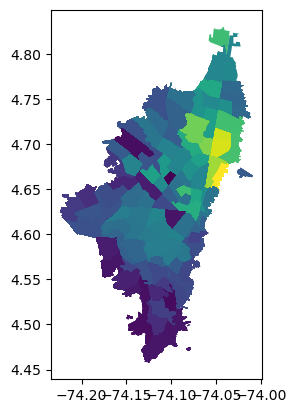

In [16]:
# s.columns
s.plot(column="ESTRATO_mean")

In [8]:
columna='Delitos Sexuales/ IntervinientesDEL 01/01/2018 AL 31/12/2018'
s=spatial_join(delito_2018, upz, columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=upz, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
display(working_df.head())
working_df.shape

CRS match.
Join has 4876 rows, whereas original point df had 5023


KeyError: 'Column not found: cantidad_delito'

# 3-Homicidios

In [10]:
### Load necessary strings

n_delito = "3"
s_delito = "homicidios"
t_delito = "Homicidios"
os.listdir(f"{gis_dir}/{n_delito}-{t_delito}")

['homicidios-2020-points.gpkg',
 'Homicidios_2021.csv',
 '.DS_Store',
 'homicidios-2018-points.gpkg',
 'homicidios-2018.csv',
 'homicidios-2019.csv',
 'homicidios-2021.csv',
 'homicidios-2020.csv',
 'homicidios-2021-points.gpkg',
 'homicidios-2019-points.gpkg']

## 2018

In [11]:
# 2018
year=2018
delito_2018 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2018.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MES',
       'MUNICIPIO_HECHO', 'FECHA_HECHO', 'EDAD', 'GENERO', 'HECHOS_ID', 'ZONA',
       'HORA_HECHO', 'CODIGO_DANE', 'HORA24', 'LATITUD', 'LONGITUD',
       'Homicidios Comunes/ IntervinientesDEL 01/01/2018 AL 10/02/2022',
       'geometry'],
      dtype='object')

In [12]:
columna='Homicidios Comunes/ IntervinientesDEL 01/01/2018 AL 10/02/2022'
s=spatial_join(delito_2018, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 1048 rows, whereas original point df had 1064


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

     2024  ESTRATO_count ESTRATO_mean ESTRATO_median  ESTRATO_stddev  \
0   38135            273     3.399267            4.0        1.015412   
1  189646            608     2.402961            2.0        1.070135   
2   40905            163     3.815951            4.0        1.410910   
3   17265            136     2.139706            3.0        1.307067   
4   11361             71     2.422535            3.0        1.516686   

                                            geometry  delitos_sexuales_2018  \
0  POLYGON ((-74.06463 4.64965, -74.06619 4.64146...                   28.0   
1  POLYGON ((-74.10579 4.75153, -74.10551 4.75263...                   75.0   
2  POLYGON ((-74.07832 4.65199, -74.07832 4.65199...                    5.0   
3  POLYGON ((-74.06784 4.60969, -74.06724 4.60928...                   45.0   
4  POLYGON ((-74.06602 4.62604, -74.06570 4.62554...                   38.0   

   tasa_delitos_sexuales_2018  homicidios_2018  tasa_homicidios_2018  
0                       82.97              3.0                  8.89  
1                       45.67             11.0                  6.70  
2                       14.04              0.0                  0.00  
3                      275.68             11.0                 67.39  
4                      378.98              0.0                  0.00  

[5 rows x 32 columns]

## 2019

In [13]:
# 2019
year=2019
delito_2019 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2019.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MES',
       'MUNICIPIO_HECHO', 'FECHA_HECHO', 'EDAD', 'GENERO', 'HECHOS_ID', 'ZONA',
       'HORA_HECHO', 'CODIGO_DANE', 'HORA24', 'LATITUD', 'LONGITUD',
       'Homicidios Comunes/ IntervinientesDEL 01/01/2018 AL 10/02/2022',
       'geometry'],
      dtype='object')

In [14]:
columna='Homicidios Comunes/ IntervinientesDEL 01/01/2018 AL 10/02/2022'
s=spatial_join(delito_2019, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 1023 rows, whereas original point df had 1035


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  ESTRATO_mean  ESTRATO_median ESTRATO_stddev  \
0     3.399267             4.0       1.015412   
1     2.402961             2.0       1.070135   
2     3.815951             4.0       1.410910   
3     2.139706             3.0       1.307067   
4     2.422535             3.0       1.516686   

                                            geometry  delitos_sexuales_2018  \
0  POLYGON ((-74.06463 4.64965, -74.06619 4.64146...                   28.0   
1  POLYGON ((-74.10579 4.75153, -74.10551 4.75263...                   75.0   
2  POLYGON ((-74.07832 4.65199, -74.07832 4.65199...                    5.0   
3  POLYGON ((-74.06784 4.60969, -74.06724 4.60928...                   45.0   
4  POLYGON ((-74.06602 4.62604, -74.06570 4.62554...                   38.0   

  tasa_delitos_sexuales_2018  homicidios_2018  tasa_homicidios_2018  \
0                      82.97              3.0                  8.89   
1                      45.67             11.0                  6.70   
2                      14.04              0.0                  0.00   
3                     275.68             11.0                 67.39   
4                     378.98              0.0                  0.00   

   homicidios_2019  tasa_homicidios_2019  
0              3.0                  8.45  
1              6.0                  3.52  
2              0.0                  0.00  
3             15.0                 89.65  
4              0.0                  0.00  

[5 rows x 34 columns]

## 2020

In [15]:
# 2020
year=2020
delito_2020 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2020.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MES',
       'MUNICIPIO_HECHO', 'FECHA_HECHO', 'EDAD', 'GENERO', 'HECHOS_ID', 'ZONA',
       'HORA_HECHO', 'CODIGO_DANE', 'HORA24', 'LATITUD', 'LONGITUD',
       'Homicidios Comunes/ IntervinientesDEL 01/01/2018 AL 10/02/2022',
       'geometry'],
      dtype='object')

In [16]:
columna='Homicidios Comunes/ IntervinientesDEL 01/01/2018 AL 10/02/2022'
s=spatial_join(delito_2020, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 1011 rows, whereas original point df had 1022


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  ESTRATO_stddev                                           geometry  \
0       1.015412  POLYGON ((-74.06463 4.64965, -74.06619 4.64146...   
1       1.070135  POLYGON ((-74.10579 4.75153, -74.10551 4.75263...   
2       1.410910  POLYGON ((-74.07832 4.65199, -74.07832 4.65199...   
3       1.307067  POLYGON ((-74.06784 4.60969, -74.06724 4.60928...   
4       1.516686  POLYGON ((-74.06602 4.62604, -74.06570 4.62554...   

  delitos_sexuales_2018 tasa_delitos_sexuales_2018  homicidios_2018  \
0                  28.0                      82.97              3.0   
1                  75.0                      45.67             11.0   
2                   5.0                      14.04              0.0   
3                  45.0                     275.68             11.0   
4                  38.0                     378.98              0.0   

  tasa_homicidios_2018  homicidios_2019  tasa_homicidios_2019  \
0                 8.89              3.0                  8.45   
1                 6.70              6.0                  3.52   
2                 0.00              0.0                  0.00   
3                67.39             15.0                 89.65   
4                 0.00              0.0                  0.00   

   homicidios_2020  tasa_homicidios_2020  
0              2.0                  5.34  
1             12.0                  6.81  
2              1.0                  2.51  
3             12.0                 70.38  
4              1.0                  9.25  

[5 rows x 36 columns]

## 2021

In [17]:
# 2021
year=2021
delito_2021 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2021.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MES',
       'MUNICIPIO_HECHO', 'FECHA_HECHO', 'EDAD', 'GENERO', 'HECHOS_ID', 'ZONA',
       'HORA_HECHO', 'CODIGO_DANE', 'HORA24', 'LATITUD', 'LONGITUD',
       'Homicidios Comunes/ IntervinientesDEL 01/01/2018 AL 10/02/2022',
       'geometry'],
      dtype='object')

In [18]:
columna='Homicidios Comunes/ IntervinientesDEL 01/01/2018 AL 10/02/2022'
s=spatial_join(delito_2021, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 1120 rows, whereas original point df had 1134


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  delitos_sexuales_2018  tasa_delitos_sexuales_2018 homicidios_2018  \
0                  28.0                       82.97             3.0   
1                  75.0                       45.67            11.0   
2                   5.0                       14.04             0.0   
3                  45.0                      275.68            11.0   
4                  38.0                      378.98             0.0   

  tasa_homicidios_2018  homicidios_2019 tasa_homicidios_2019  homicidios_2020  \
0                 8.89              3.0                 8.45              2.0   
1                 6.70              6.0                 3.52             12.0   
2                 0.00              0.0                 0.00              1.0   
3                67.39             15.0                89.65             12.0   
4                 0.00              0.0                 0.00              1.0   

   tasa_homicidios_2020  homicidios_2021  tasa_homicidios_2021  
0                  5.34              4.0                 10.28  
1                  6.81              6.0                  3.33  
2                  2.51              4.0                  9.65  
3                 70.38             20.0                116.60  
4                  9.25              2.0                 18.17  

[5 rows x 38 columns]

# 4-Violencia intrafamiliar

In [19]:
### Load necessary strings

n_delito = "4"
s_delito = "violencia_intrafamiliar"
t_delito = "Violencia intrafamiliar"
os.listdir(f"{gis_dir}/{n_delito}-{t_delito}")

['violencia_intrafamiliar-2018.csv',
 'violencia_intrafamiliar-2018-points.gpkg']

## 2018

In [20]:
# 2018
year=2018
delito_2018 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2018.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'DEPTO_HECHO', 'MES', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'CLASE_SITIO', 'DESCRIPCION_CONDUCTA', 'EDAD',
       'ESTADO_CIVIL_PERSONA', 'GENERO', 'DIA_SEMANA', 'MOVIL_AGRESOR',
       'MOVIL_VICTIMA', 'ZONA', 'HORA_HECHO', 'CODIGO_DANE', 'DIRECCION_HECHO',
       'TITULO_CONDUCTA', 'PAIS_PERSONA', 'NUMERO UNICO HECHOS',
       'IDENTIFICACION', 'TIPO_IDENTIFICACION', 'LATITUD', 'LONGITUD',
       'Violencia Intrafamiliar/ IntervinientesDEL 01/01/2018 AL 30/04/2018',
       'geometry'],
      dtype='object')

In [21]:
columna='Violencia Intrafamiliar/ IntervinientesDEL 01/01/2018 AL 30/04/2018'
s=spatial_join(delito_2018, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 33220 rows, whereas original point df had 33616


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  homicidios_2018  tasa_homicidios_2018 homicidios_2019 tasa_homicidios_2019  \
0             3.0                  8.89             3.0                 8.45   
1            11.0                  6.70             6.0                 3.52   
2             0.0                  0.00             0.0                 0.00   
3            11.0                 67.39            15.0                89.65   
4             0.0                  0.00             0.0                 0.00   

   homicidios_2020 tasa_homicidios_2020  homicidios_2021  \
0              2.0                 5.34              4.0   
1             12.0                 6.81              6.0   
2              1.0                 2.51              4.0   
3             12.0                70.38             20.0   
4              1.0                 9.25              2.0   

   tasa_homicidios_2021  violencia_intrafamiliar_2018  \
0                 10.28                           143   
1                  3.33                           520   
2                  9.65                            97   
3                116.60                           120   
4                 18.17                            80   

   tasa_violencia_intrafamiliar_2018  
0                             423.72  
1                             316.62  
2                             272.32  
3                             735.16  
4                             797.85  

[5 rows x 40 columns]

# 6-Hurto a personas

In [22]:
### Load necessary strings

n_delito = "6"
s_delito = "hurto_a_personas"
t_delito = "Hurto a personas"
os.listdir(f"{gis_dir}/{n_delito}-{t_delito}")

['hurto_a_personas-2021-points.gpkg',
 'hurto_a_personas-2019-points.gpkg',
 'hurto_a_personas-2020-points.gpkg',
 'hurto_a_personas-2019.csv',
 'hurto_a_personas-2018-points.gpkg',
 'hurto_a_personas-2018.csv',
 'Hurto a personas_2021.csv',
 'hurto_a_personas-2020.csv',
 'hurto_a_personas-2021.csv']

## 2018

In [23]:
# 2018
year=2018
delito_2018 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2018.columns


Index(['year', 'armas', 'modalidad', 'dpto', 'mun', 'fecha', 'edad', 'genero',
       'hechos', 'hora', 'cod_dane', 'hora_24', 'lat', 'lon', 'cantidad',
       'Unnamed: 15', 'geometry'],
      dtype='object')

In [24]:
columna='cantidad'
s=spatial_join(delito_2018, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 104936 rows, whereas original point df had 105358


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  homicidios_2019  tasa_homicidios_2019 homicidios_2020 tasa_homicidios_2020  \
0             3.0                  8.45             2.0                 5.34   
1             6.0                  3.52            12.0                 6.81   
2             0.0                  0.00             1.0                 2.51   
3            15.0                 89.65            12.0                70.38   
4             0.0                  0.00             1.0                 9.25   

   homicidios_2021 tasa_homicidios_2021  violencia_intrafamiliar_2018  \
0              4.0                10.28                           143   
1              6.0                 3.33                           520   
2              4.0                 9.65                            97   
3             20.0               116.60                           120   
4              2.0                18.17                            80   

   tasa_violencia_intrafamiliar_2018  hurto_a_personas_2018  \
0                             423.72                   1770   
1                             316.62                   1472   
2                             272.32                    486   
3                             735.16                   4369   
4                             797.85                   1546   

   tasa_hurto_a_personas_2018  
0                     5244.60  
1                      896.29  
2                     1364.40  
3                    26765.91  
4                    15418.37  

[5 rows x 42 columns]

## 2019

In [25]:
# 2019
year=2019
delito_2019 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2019.columns


Index(['year', 'armas', 'modalidad', 'dpto', 'mun', 'fecha', 'edad', 'genero',
       'hechos', 'hora', 'cod_dane', 'hora_24', 'lat', 'lon', 'cantidad',
       'Unnamed: 15', 'geometry'],
      dtype='object')

In [26]:
columna='cantidad'
s=spatial_join(delito_2019, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 127013 rows, whereas original point df had 127498


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  homicidios_2020  tasa_homicidios_2020 homicidios_2021 tasa_homicidios_2021  \
0             2.0                  5.34             4.0                10.28   
1            12.0                  6.81             6.0                 3.33   
2             1.0                  2.51             4.0                 9.65   
3            12.0                 70.38            20.0               116.60   
4             1.0                  9.25             2.0                18.17   

   violencia_intrafamiliar_2018 tasa_violencia_intrafamiliar_2018  \
0                           143                            423.72   
1                           520                            316.62   
2                            97                            272.32   
3                           120                            735.16   
4                            80                            797.85   

   hurto_a_personas_2018  tasa_hurto_a_personas_2018  hurto_a_personas_2019  \
0                   1770                     5244.60                   2205   
1                   1472                      896.29                   1750   
2                    486                     1364.40                    599   
3                   4369                    26765.91                   4971   
4                   1546                    15418.37                   1740   

   tasa_hurto_a_personas_2019  
0                     6212.49  
1                     1025.53  
2                     1593.72  
3                    29709.54  
4                    16642.75  

[5 rows x 44 columns]

## 2020

In [27]:
# 2020
year=2020
delito_2020 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2020.columns


Index(['year', 'armas', 'modalidad', 'dpto', 'mun', 'fecha', 'edad', 'genero',
       'hechos', 'hora', 'cod_dane', 'hora_24', 'lat', 'lon', 'cantidad',
       'Unnamed: 15', 'geometry'],
      dtype='object')

In [28]:
columna='cantidad'
s=spatial_join(delito_2020, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 82810 rows, whereas original point df had 83087


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  homicidios_2021  tasa_homicidios_2021 violencia_intrafamiliar_2018  \
0             4.0                 10.28                          143   
1             6.0                  3.33                          520   
2             4.0                  9.65                           97   
3            20.0                116.60                          120   
4             2.0                 18.17                           80   

  tasa_violencia_intrafamiliar_2018  hurto_a_personas_2018  \
0                            423.72                   1770   
1                            316.62                   1472   
2                            272.32                    486   
3                            735.16                   4369   
4                            797.85                   1546   

  tasa_hurto_a_personas_2018  hurto_a_personas_2019  \
0                    5244.60                   2205   
1                     896.29                   1750   
2                    1364.40                    599   
3                   26765.91                   4971   
4                   15418.37                   1740   

   tasa_hurto_a_personas_2019  hurto_a_personas_2020  \
0                     6212.49                   1054   
1                     1025.53                   1306   
2                     1593.72                    329   
3                    29709.54                   2225   
4                    16642.75                    649   

   tasa_hurto_a_personas_2020  
0                     2814.49  
1                      741.18  
2                      826.97  
3                    13049.85  
4                     6005.37  

[5 rows x 46 columns]

## 2021

In [29]:
# 2021
year=2021
delito_2021 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2021.columns


Index(['year', 'armas', 'modalidad', 'dpto', 'mun', 'fecha', 'edad', 'genero',
       'hechos', 'hora', 'cod_dane', 'hora_24', 'lat', 'lon', 'cantidad',
       'Unnamed: 15', 'geometry'],
      dtype='object')

In [30]:
columna='cantidad'
s=spatial_join(delito_2021, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.


Join has 107189 rows, whereas original point df had 107533


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  violencia_intrafamiliar_2018  tasa_violencia_intrafamiliar_2018  \
0                          143                             423.72   
1                          520                             316.62   
2                           97                             272.32   
3                          120                             735.16   
4                           80                             797.85   

  hurto_a_personas_2018 tasa_hurto_a_personas_2018  hurto_a_personas_2019  \
0                  1770                    5244.60                   2205   
1                  1472                     896.29                   1750   
2                   486                    1364.40                    599   
3                  4369                   26765.91                   4971   
4                  1546                   15418.37                   1740   

  tasa_hurto_a_personas_2019  hurto_a_personas_2020  \
0                    6212.49                   1054   
1                    1025.53                   1306   
2                    1593.72                    329   
3                   29709.54                   2225   
4                   16642.75                    649   

   tasa_hurto_a_personas_2020  hurto_a_personas_2021  \
0                     2814.49                   1544   
1                      741.18                   1520   
2                      826.97                    484   
3                    13049.85                   2649   
4                     6005.37                    871   

   tasa_hurto_a_personas_2021  
0                     3968.54  
1                      843.43  
2                     1167.70  
3                    15443.36  
4                     7913.87  

[5 rows x 48 columns]

# 7-Hurto a residencias

In [31]:
### Load necessary strings

n_delito = "7"
s_delito = "hurto_a_residencias"
t_delito = "Hurto a residencias"
os.listdir(f"{gis_dir}/{n_delito}-{t_delito}")

['hurto_a_residencias-2018-points.gpkg', 'hurto_a_residencias-2018.csv']

## 2018

In [32]:
# 2018
year=2018
delito_2018 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2018.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'DEPTO_HECHO', 'MES', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'CLASE_SITIO', 'DESCRIPCION_CONDUCTA', 'EDAD',
       'ESTADO_CIVIL_PERSONA', 'GENERO', 'DIA_SEMANA', 'MOVIL_AGRESOR',
       'MOVIL_VICTIMA', 'ZONA', 'HORA_HECHO', 'CODIGO_DANE', 'DIRECCION_HECHO',
       'TITULO_CONDUCTA', 'PAIS_PERSONA', 'NUMERO UNICO HECHOS',
       'IDENTIFICACION', 'TIPO_IDENTIFICACION', 'LATITUD', 'LONGITUD',
       'Hurto Residencias/ IntervinientesDEL 01/01/2018 AL 31/12/2018',
       'geometry'],
      dtype='object')

In [33]:
columna='Hurto Residencias/ IntervinientesDEL 01/01/2018 AL 31/12/2018'
s=spatial_join(delito_2018, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 9865 rows, whereas original point df had 9918


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_a_personas_2018  tasa_hurto_a_personas_2018 hurto_a_personas_2019  \
0                  1770                     5244.60                  2205   
1                  1472                      896.29                  1750   
2                   486                     1364.40                   599   
3                  4369                    26765.91                  4971   
4                  1546                    15418.37                  1740   

  tasa_hurto_a_personas_2019  hurto_a_personas_2020  \
0                    6212.49                   1054   
1                    1025.53                   1306   
2                    1593.72                    329   
3                   29709.54                   2225   
4                   16642.75                    649   

  tasa_hurto_a_personas_2020  hurto_a_personas_2021  \
0                    2814.49                   1544   
1                     741.18                   1520   
2                     826.97                    484   
3                   13049.85                   2649   
4                    6005.37                    871   

   tasa_hurto_a_personas_2021  hurto_a_residencias_2018  \
0                     3968.54                       121   
1                      843.43                       162   
2                     1167.70                        70   
3                    15443.36                        53   
4                     7913.87                        25   

   tasa_hurto_a_residencias_2018  
0                         358.53  
1                          98.64  
2                         196.52  
3                         324.70  
4                         249.33  

[5 rows x 50 columns]

# 8-Hurto de automotores

In [34]:
### Load necessary strings

n_delito = "8"
s_delito = "hurto_automotores"
t_delito = "Hurto de automotores"
os.listdir(f"{gis_dir}/{n_delito}-{t_delito}")

['hurto_automotores-2021-points.gpkg',
 'hurto_automotores-2020.csv',
 'hurto_automotores-2021.csv',
 'hurto_automotores-2019-points.gpkg',
 'hurto_automotores-2019.csv',
 'hurto_automotores-2018.csv',
 'hurto_automotores-2020-points.gpkg',
 'hurto_automotores-2018-points.gpkg']

## 2018

In [35]:
# 2018
year=2018
delito_2018 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2018.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'EDAD', 'GENERO', 'HECHOS_ID', 'HORA_HECHO',
       'CODIGO_DANE', 'HORA24', 'LATITUD', 'LONGITUD',
       'Hurto Automotores/ HechosDEL 01/01/2018 AL 10/02/2022', 'geometry'],
      dtype='object')

In [36]:
columna='Hurto Automotores/ HechosDEL 01/01/2018 AL 10/02/2022'
s=spatial_join(delito_2018, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 3889 rows, whereas original point df had 3900


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_a_personas_2019  tasa_hurto_a_personas_2019 hurto_a_personas_2020  \
0                  2205                     6212.49                  1054   
1                  1750                     1025.53                  1306   
2                   599                     1593.72                   329   
3                  4971                    29709.54                  2225   
4                  1740                    16642.75                   649   

  tasa_hurto_a_personas_2020  hurto_a_personas_2021  \
0                    2814.49                   1544   
1                     741.18                   1520   
2                     826.97                    484   
3                   13049.85                   2649   
4                    6005.37                    871   

  tasa_hurto_a_personas_2021  hurto_a_residencias_2018  \
0                    3968.54                       121   
1                     843.43                       162   
2                    1167.70                        70   
3                   15443.36                        53   
4                    7913.87                        25   

   tasa_hurto_a_residencias_2018  hurto_automotores_2018  \
0                         358.53                    35.0   
1                          98.64                    48.0   
2                         196.52                    12.0   
3                         324.70                    13.0   
4                         249.33                    11.0   

   tasa_hurto_automotores_2018  
0                       103.71  
1                        29.23  
2                        33.69  
3                        79.64  
4                       109.70  

[5 rows x 52 columns]

## 2019

In [37]:
# 2019
year=2019
delito_2019 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2019.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'EDAD', 'GENERO', 'HECHOS_ID', 'HORA_HECHO',
       'CODIGO_DANE', 'HORA24', 'LATITUD', 'LONGITUD',
       'Hurto Automotores/ HechosDEL 01/01/2018 AL 10/02/2022', 'geometry'],
      dtype='object')

In [38]:
columna='Hurto Automotores/ HechosDEL 01/01/2018 AL 10/02/2022'
s=spatial_join(delito_2019, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 4134 rows, whereas original point df had 4156


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_a_personas_2020  tasa_hurto_a_personas_2020 hurto_a_personas_2021  \
0                  1054                     2814.49                  1544   
1                  1306                      741.18                  1520   
2                   329                      826.97                   484   
3                  2225                    13049.85                  2649   
4                   649                     6005.37                   871   

  tasa_hurto_a_personas_2021  hurto_a_residencias_2018  \
0                    3968.54                       121   
1                     843.43                       162   
2                    1167.70                        70   
3                   15443.36                        53   
4                    7913.87                        25   

  tasa_hurto_a_residencias_2018  hurto_automotores_2018  \
0                        358.53                    35.0   
1                         98.64                    48.0   
2                        196.52                    12.0   
3                        324.70                    13.0   
4                        249.33                    11.0   

   tasa_hurto_automotores_2018  hurto_automotores_2019  \
0                       103.71                    31.0   
1                        29.23                    43.0   
2                        33.69                    13.0   
3                        79.64                    20.0   
4                       109.70                     6.0   

   tasa_hurto_automotores_2019  
0                        87.34  
1                        25.20  
2                        34.59  
3                       119.53  
4                        57.39  

[5 rows x 54 columns]

## 2020

In [39]:
# 2020
year=2020
delito_2020 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2020.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'EDAD', 'GENERO', 'HECHOS_ID', 'HORA_HECHO',
       'CODIGO_DANE', 'HORA24', 'LATITUD', 'LONGITUD',
       'Hurto Automotores/ HechosDEL 01/01/2018 AL 10/02/2022', 'geometry'],
      dtype='object')

In [40]:
columna='Hurto Automotores/ HechosDEL 01/01/2018 AL 10/02/2022'
s=spatial_join(delito_2020, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 4006 rows, whereas original point df had 4022


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_a_personas_2021  tasa_hurto_a_personas_2021 hurto_a_residencias_2018  \
0                  1544                     3968.54                      121   
1                  1520                      843.43                      162   
2                   484                     1167.70                       70   
3                  2649                    15443.36                       53   
4                   871                     7913.87                       25   

  tasa_hurto_a_residencias_2018  hurto_automotores_2018  \
0                        358.53                    35.0   
1                         98.64                    48.0   
2                        196.52                    12.0   
3                        324.70                    13.0   
4                        249.33                    11.0   

  tasa_hurto_automotores_2018  hurto_automotores_2019  \
0                      103.71                    31.0   
1                       29.23                    43.0   
2                       33.69                    13.0   
3                       79.64                    20.0   
4                      109.70                     6.0   

   tasa_hurto_automotores_2019  hurto_automotores_2020  \
0                        87.34                    17.0   
1                        25.20                    52.0   
2                        34.59                    15.0   
3                       119.53                    27.0   
4                        57.39                     6.0   

   tasa_hurto_automotores_2020  
0                        45.40  
1                        29.51  
2                        37.70  
3                       158.36  
4                        55.52  

[5 rows x 56 columns]

## 2021

In [41]:
# 2021
year=2021
delito_2021 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2021.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'EDAD', 'GENERO', 'HECHOS_ID', 'HORA_HECHO',
       'CODIGO_DANE', 'HORA24', 'LATITUD', 'LONGITUD',
       'Hurto Automotores/ HechosDEL 01/01/2018 AL 10/02/2022', 'geometry'],
      dtype='object')

In [42]:
columna='Hurto Automotores/ HechosDEL 01/01/2018 AL 10/02/2022'
s=spatial_join(delito_2021, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 4177 rows, whereas original point df had 4191


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_a_residencias_2018  tasa_hurto_a_residencias_2018  \
0                      121                         358.53   
1                      162                          98.64   
2                       70                         196.52   
3                       53                         324.70   
4                       25                         249.33   

  hurto_automotores_2018 tasa_hurto_automotores_2018  hurto_automotores_2019  \
0                   35.0                      103.71                    31.0   
1                   48.0                       29.23                    43.0   
2                   12.0                       33.69                    13.0   
3                   13.0                       79.64                    20.0   
4                   11.0                      109.70                     6.0   

  tasa_hurto_automotores_2019  hurto_automotores_2020  \
0                       87.34                    17.0   
1                       25.20                    52.0   
2                       34.59                    15.0   
3                      119.53                    27.0   
4                       57.39                     6.0   

   tasa_hurto_automotores_2020  hurto_automotores_2021  \
0                        45.40                    20.0   
1                        29.51                    47.0   
2                        37.70                    18.0   
3                       158.36                     9.0   
4                        55.52                    13.0   

   tasa_hurto_automotores_2021  
0                        51.41  
1                        26.08  
2                        43.43  
3                        52.47  
4                       118.12  

[5 rows x 58 columns]

# 9-Hurto de motocicletas

In [43]:
### Load necessary strings

n_delito = "9"
s_delito = "hurto_motocicletas"
t_delito = "Hurto de motocicletas"
os.listdir(f"{gis_dir}/{n_delito}-{t_delito}")

['hurto_motocicletas-2019-points.gpkg',
 'hurto_motocicletas-2021-points.gpkg',
 'hurto_motocicletas-2021.csv',
 'hurto_motocicletas-2020.csv',
 'hurto_motocicletas-2018.csv',
 'hurto_motocicletas-2019.csv',
 'hurto_motocicletas-2018-points.gpkg',
 'hurto_motocicletas-2020-points.gpkg']

## 2018

In [44]:
# 2018
year=2018
delito_2018 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2018.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'EDAD', 'GENERO', 'HORA_HECHO', 'CODIGO_DANE', 'HORA24',
       'LATITUD', 'LONGITUD',
       'Hurto Motocicletas/ IntervinientesDEL 01/01/2018 AL 31/12/2018',
       'geometry'],
      dtype='object')

In [45]:
columna='Hurto Motocicletas/ IntervinientesDEL 01/01/2018 AL 31/12/2018'
s=spatial_join(delito_2018, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 3987 rows, whereas original point df had 3994


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_automotores_2018  tasa_hurto_automotores_2018 hurto_automotores_2019  \
0                   35.0                       103.71                   31.0   
1                   48.0                        29.23                   43.0   
2                   12.0                        33.69                   13.0   
3                   13.0                        79.64                   20.0   
4                   11.0                       109.70                    6.0   

  tasa_hurto_automotores_2019  hurto_automotores_2020  \
0                       87.34                    17.0   
1                       25.20                    52.0   
2                       34.59                    15.0   
3                      119.53                    27.0   
4                       57.39                     6.0   

  tasa_hurto_automotores_2020  hurto_automotores_2021  \
0                       45.40                    20.0   
1                       29.51                    47.0   
2                       37.70                    18.0   
3                      158.36                     9.0   
4                       55.52                    13.0   

   tasa_hurto_automotores_2021  hurto_motocicletas_2018  \
0                        51.41                     10.0   
1                        26.08                     52.0   
2                        43.43                      2.0   
3                        52.47                      9.0   
4                       118.12                      6.0   

   tasa_hurto_motocicletas_2018  
0                         29.63  
1                         31.66  
2                          5.61  
3                         55.14  
4                         59.84  

[5 rows x 60 columns]

## 2019

In [46]:
# 2019
year=2019
delito_2019 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2019.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'EDAD', 'GENERO', 'HORA_HECHO', 'CODIGO_DANE', 'HORA24',
       'LATITUD', 'LONGITUD',
       'Hurto Motocicletas/ IntervinientesDEL 01/01/2018 AL 31/12/2018',
       'geometry'],
      dtype='object')

In [47]:
columna='Hurto Motocicletas/ IntervinientesDEL 01/01/2018 AL 31/12/2018'
s=spatial_join(delito_2019, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 4497 rows, whereas original point df had 4513


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_automotores_2019  tasa_hurto_automotores_2019 hurto_automotores_2020  \
0                   31.0                        87.34                   17.0   
1                   43.0                        25.20                   52.0   
2                   13.0                        34.59                   15.0   
3                   20.0                       119.53                   27.0   
4                    6.0                        57.39                    6.0   

  tasa_hurto_automotores_2020  hurto_automotores_2021  \
0                       45.40                    20.0   
1                       29.51                    47.0   
2                       37.70                    18.0   
3                      158.36                     9.0   
4                       55.52                    13.0   

  tasa_hurto_automotores_2021  hurto_motocicletas_2018  \
0                       51.41                     10.0   
1                       26.08                     52.0   
2                       43.43                      2.0   
3                       52.47                      9.0   
4                      118.12                      6.0   

   tasa_hurto_motocicletas_2018  hurto_motocicletas_2019  \
0                         29.63                     16.0   
1                         31.66                     58.0   
2                          5.61                      7.0   
3                         55.14                     21.0   
4                         59.84                      5.0   

   tasa_hurto_motocicletas_2019  
0                         45.08  
1                         33.99  
2                         18.62  
3                        125.51  
4                         47.82  

[5 rows x 62 columns]

## 2020

In [48]:
# 2020
year=2020
delito_2020 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2020.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'EDAD', 'GENERO', 'HORA_HECHO', 'CODIGO_DANE', 'HORA24',
       'LATITUD', 'LONGITUD',
       'Hurto Motocicletas/ IntervinientesDEL 01/01/2018 AL 31/12/2018',
       'geometry'],
      dtype='object')

In [49]:
columna='Hurto Motocicletas/ IntervinientesDEL 01/01/2018 AL 31/12/2018'
s=spatial_join(delito_2020, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 4095 rows, whereas original point df had 4109


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_automotores_2020  tasa_hurto_automotores_2020 hurto_automotores_2021  \
0                   17.0                        45.40                   20.0   
1                   52.0                        29.51                   47.0   
2                   15.0                        37.70                   18.0   
3                   27.0                       158.36                    9.0   
4                    6.0                        55.52                   13.0   

  tasa_hurto_automotores_2021  hurto_motocicletas_2018  \
0                       51.41                     10.0   
1                       26.08                     52.0   
2                       43.43                      2.0   
3                       52.47                      9.0   
4                      118.12                      6.0   

  tasa_hurto_motocicletas_2018  hurto_motocicletas_2019  \
0                        29.63                     16.0   
1                        31.66                     58.0   
2                         5.61                      7.0   
3                        55.14                     21.0   
4                        59.84                      5.0   

   tasa_hurto_motocicletas_2019  hurto_motocicletas_2020  \
0                         45.08                     16.0   
1                         33.99                     78.0   
2                         18.62                      7.0   
3                        125.51                     11.0   
4                         47.82                      2.0   

   tasa_hurto_motocicletas_2020  
0                         42.72  
1                         44.27  
2                         17.60  
3                         64.52  
4                         18.51  

[5 rows x 64 columns]

## 2021

In [50]:
# 2021
year=2021
delito_2021 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2021.columns

Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'EDAD', 'GENERO', 'HORA_HECHO', 'CODIGO_DANE', 'HORA24',
       'LATITUD', 'LONGITUD',
       'Hurto Motocicletas/ IntervinientesDEL 01/01/2018 AL 31/12/2018',
       'geometry'],
      dtype='object')

In [51]:
columna='Hurto Motocicletas/ IntervinientesDEL 01/01/2018 AL 31/12/2018'
s=spatial_join(delito_2021, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 5060 rows, whereas original point df had 5094


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_automotores_2021  tasa_hurto_automotores_2021 hurto_motocicletas_2018  \
0                   20.0                        51.41                    10.0   
1                   47.0                        26.08                    52.0   
2                   18.0                        43.43                     2.0   
3                    9.0                        52.47                     9.0   
4                   13.0                       118.12                     6.0   

  tasa_hurto_motocicletas_2018  hurto_motocicletas_2019  \
0                        29.63                     16.0   
1                        31.66                     58.0   
2                         5.61                      7.0   
3                        55.14                     21.0   
4                        59.84                      5.0   

  tasa_hurto_motocicletas_2019  hurto_motocicletas_2020  \
0                        45.08                     16.0   
1                        33.99                     78.0   
2                        18.62                      7.0   
3                       125.51                     11.0   
4                        47.82                      2.0   

   tasa_hurto_motocicletas_2020  hurto_motocicletas_2021  \
0                         42.72                     29.0   
1                         44.27                     61.0   
2                         17.60                     10.0   
3                         64.52                     21.0   
4                         18.51                     11.0   

   tasa_hurto_motocicletas_2021  
0                         74.54  
1                         33.85  
2                         24.13  
3                        122.43  
4                         99.95  

[5 rows x 66 columns]

# 10-Hurto a comercios

In [52]:
### Load necessary strings

n_delito = "10"
s_delito = "hurto_comercios"
t_delito = "Hurto a comercios"
os.listdir(f"{gis_dir}/{n_delito}-{t_delito}")

['hurto_comercios-2018-points.gpkg',
 'hurto_comercios-2020-points.gpkg',
 'hurto_comercios-2019-points.gpkg',
 'hurto_comercios-2021.csv',
 'hurto_comercios-2020.csv',
 'hurto_comercios-2018.csv',
 'hurto_comercios-2019.csv',
 'hurto_comercios-2021-points.gpkg']

## 2018

In [53]:
# 2018
year=2018
delito_2018 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2018.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'HORA_HECHO', 'CODIGO_DANE', 'HORA24', 'LATITUD',
       'LONGITUD',
       'Hurto Comercio/ Intervinientes_x000D_DEL 01/01/2018 AL 31/12/2018',
       'geometry'],
      dtype='object')

In [54]:
columna='Hurto Comercio/ Intervinientes_x000D_DEL 01/01/2018 AL 31/12/2018'
s=spatial_join(delito_2018, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 18484 rows, whereas original point df had 18602


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_motocicletas_2018  tasa_hurto_motocicletas_2018  \
0                    10.0                         29.63   
1                    52.0                         31.66   
2                     2.0                          5.61   
3                     9.0                         55.14   
4                     6.0                         59.84   

  hurto_motocicletas_2019 tasa_hurto_motocicletas_2019  \
0                    16.0                        45.08   
1                    58.0                        33.99   
2                     7.0                        18.62   
3                    21.0                       125.51   
4                     5.0                        47.82   

   hurto_motocicletas_2020 tasa_hurto_motocicletas_2020  \
0                     16.0                        42.72   
1                     78.0                        44.27   
2                      7.0                        17.60   
3                     11.0                        64.52   
4                      2.0                        18.51   

   hurto_motocicletas_2021  tasa_hurto_motocicletas_2021  \
0                     29.0                         74.54   
1                     61.0                         33.85   
2                     10.0                         24.13   
3                     21.0                        122.43   
4                     11.0                         99.95   

   hurto_comercios_2018  tasa_hurto_comercios_2018  
0                 264.0                     782.25  
1                 278.0                     169.27  
2                  56.0                     157.22  
3                 460.0                    2818.11  
4                 277.0                    2762.54  

[5 rows x 68 columns]

## 2019

In [55]:
# 2019
year=2019
delito_2019 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2019.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'HORA_HECHO', 'CODIGO_DANE', 'HORA24', 'LATITUD',
       'LONGITUD',
       'Hurto Comercio/ Intervinientes_x000D_DEL 01/01/2018 AL 31/12/2018',
       'geometry'],
      dtype='object')

In [56]:
columna='Hurto Comercio/ Intervinientes_x000D_DEL 01/01/2018 AL 31/12/2018'
s=spatial_join(delito_2019, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 18260 rows, whereas original point df had 18519


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_motocicletas_2019  tasa_hurto_motocicletas_2019  \
0                    16.0                         45.08   
1                    58.0                         33.99   
2                     7.0                         18.62   
3                    21.0                        125.51   
4                     5.0                         47.82   

  hurto_motocicletas_2020 tasa_hurto_motocicletas_2020  \
0                    16.0                        42.72   
1                    78.0                        44.27   
2                     7.0                        17.60   
3                    11.0                        64.52   
4                     2.0                        18.51   

   hurto_motocicletas_2021 tasa_hurto_motocicletas_2021  hurto_comercios_2018  \
0                     29.0                        74.54                 264.0   
1                     61.0                        33.85                 278.0   
2                     10.0                        24.13                  56.0   
3                     21.0                       122.43                 460.0   
4                     11.0                        99.95                 277.0   

   tasa_hurto_comercios_2018  hurto_comercios_2019  tasa_hurto_comercios_2019  
0                     782.25                 248.0                     698.73  
1                     169.27                 308.0                     180.49  
2                     157.22                  79.0                     210.19  
3                    2818.11                 484.0                    2892.66  
4                    2762.54                 188.0                    1798.18  

[5 rows x 70 columns]

## 2020

In [57]:
# 2020
year=2020
delito_2020 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2020.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'HORA_HECHO', 'CODIGO_DANE', 'HORA24', 'LATITUD',
       'LONGITUD',
       'Hurto Comercio/ Intervinientes_x000D_DEL 01/01/2018 AL 31/12/2018',
       'geometry'],
      dtype='object')

In [58]:
columna='Hurto Comercio/ Intervinientes_x000D_DEL 01/01/2018 AL 31/12/2018'
s=spatial_join(delito_2020, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 11761 rows, whereas original point df had 11824


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_motocicletas_2020  tasa_hurto_motocicletas_2020  \
0                    16.0                         42.72   
1                    78.0                         44.27   
2                     7.0                         17.60   
3                    11.0                         64.52   
4                     2.0                         18.51   

  hurto_motocicletas_2021 tasa_hurto_motocicletas_2021  hurto_comercios_2018  \
0                    29.0                        74.54                 264.0   
1                    61.0                        33.85                 278.0   
2                    10.0                        24.13                  56.0   
3                    21.0                       122.43                 460.0   
4                    11.0                        99.95                 277.0   

  tasa_hurto_comercios_2018  hurto_comercios_2019  tasa_hurto_comercios_2019  \
0                    782.25                 248.0                     698.73   
1                    169.27                 308.0                     180.49   
2                    157.22                  79.0                     210.19   
3                   2818.11                 484.0                    2892.66   
4                   2762.54                 188.0                    1798.18   

   hurto_comercios_2020  tasa_hurto_comercios_2020  
0                 169.0                     451.28  
1                 185.0                     104.99  
2                  33.0                      82.95  
3                 245.0                    1436.95  
4                 121.0                    1119.64  

[5 rows x 72 columns]

## 2021

In [59]:
# 2021
year=2021
delito_2021 = gpd.read_file(f"{gis_dir}/{n_delito}-{t_delito}/{s_delito}-{year}-points.gpkg")
delito_2021.columns


Index(['AÑO', 'ARMAS_MEDIOS', 'MODALIDAD', 'DEPTO_HECHO', 'MUNICIPIO_HECHO',
       'FECHA_HECHO', 'HORA_HECHO', 'CODIGO_DANE', 'HORA24', 'LATITUD',
       'LONGITUD',
       'Hurto Comercio/ Intervinientes_x000D_DEL 01/01/2018 AL 31/12/2018',
       'geometry'],
      dtype='object')

In [60]:
columna='Hurto Comercio/ Intervinientes_x000D_DEL 01/01/2018 AL 31/12/2018'
s=spatial_join(delito_2021, working_df, crime_count_column=columna)
working_df=group_and_merge(sjoin_df=s, mergeleft_df=working_df, string_crime_name=s_delito, string_year=year)
gen_crime_rate(working_df, s_delito, year)
working_df.head()

CRS match.
Join has 9691 rows, whereas original point df had 9759


objectid           nombre zona_estaci decreto_pot  \
0      455         GALERIAS           B         190   
1      468             SUBA           C         190   
2      474     LA ESMERALDA           B         619   
3      484       LAS NIEVES           C         190   
4      459  SAGRADO CORAZON           B         190   

                                             decreto    shape_area  \
0                                    Dec 621 de 2006  2.375681e+06   
1  Dec 615 de 2006 Mod.=Dec 0476 de 2008, 007 de ...  6.529011e+06   
2                                    Dec 928 de 2001  1.928785e+06   
3  Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...  1.725739e+06   
4  Dec 492 de 2007 Mod.=Res 249 de 2009, Dec 093 ...  1.467630e+06   

      shape_len codigo_id  escala_capt                fecha_captu  ...  \
0   6709.438765       100          NaN  2011-09-21 21:00:00-05:00  ...   
1  13752.691670        27          NaN  2011-09-21 21:00:00-05:00  ...   
2   6002.072649       106          NaN  2011-09-21 21:00:00-05:00  ...   
3   6852.673151        93          NaN  2011-09-21 21:00:00-05:00  ...   
4   7191.132524        91          NaN  2011-09-21 21:00:00-05:00  ...   

  hurto_motocicletas_2021  tasa_hurto_motocicletas_2021 hurto_comercios_2018  \
0                    29.0                         74.54                264.0   
1                    61.0                         33.85                278.0   
2                    10.0                         24.13                 56.0   
3                    21.0                        122.43                460.0   
4                    11.0                         99.95                277.0   

  tasa_hurto_comercios_2018  hurto_comercios_2019 tasa_hurto_comercios_2019  \
0                    782.25                 248.0                    698.73   
1                    169.27                 308.0                    180.49   
2                    157.22                  79.0                    210.19   
3                   2818.11                 484.0                   2892.66   
4                   2762.54                 188.0                   1798.18   

   hurto_comercios_2020  tasa_hurto_comercios_2020  hurto_comercios_2021  \
0                 169.0                     451.28                 131.0   
1                 185.0                     104.99                 124.0   
2                  33.0                      82.95                  47.0   
3                 245.0                    1436.95                 252.0   
4                 121.0                    1119.64                 105.0   

   tasa_hurto_comercios_2021  
0                     336.71  
1                      68.81  
2                     113.39  
3                    1469.13  
4                     954.03  

[5 rows x 74 columns]

In [61]:
# View number of crime points that did not join


# Export geopackage

In [62]:
# Export
# At the end of this processing I should have only one gpkg and CSV in wide format with
# the localidades and all the crimes per year plus the strata, and population.
# There should be 23 variables with data on crimes, and 23 variables with the
# crime rate for the crimes, thus 46 new variables in total to work with.


working_df.to_csv(f"{data_dir}/3-AnalysisData/delitos_por_upz.csv")
working_df.to_file(f"{data_dir}/3-AnalysisData/delitos_por_upz.gpkg", driver="GPKG")

In [63]:
len(working_df.columns[28:])

46